In this notebook we are going to extract the average sentiment scores based on LDA-extracted topic modelling of the review data

In [ ]:
#Import packages
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from langdetect import detect, LangDetectException
import numpy as np
from joblib import dump, load  # For saving and loading models
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from langdetect import detect, LangDetectException
from collections import Counter
import scipy.sparse
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


In [ ]:
# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of column content
pd.set_option('display.max_rows', None)  # Show all rows
# Read reviews from csv files
reviews_madrid=pd.read_csv('reviews_madrid.csv.gz')
reviews_singapore=pd.read_csv('reviews_singapore.csv.gz')
reviews_madrid['city']='Madrid'
reviews_singapore['city']='Singapore'

In [2]:
reviews_combined=pd.concat([reviews_madrid,reviews_singapore],axis=0)

In [3]:
reviews_combined.shape

(1267742, 7)

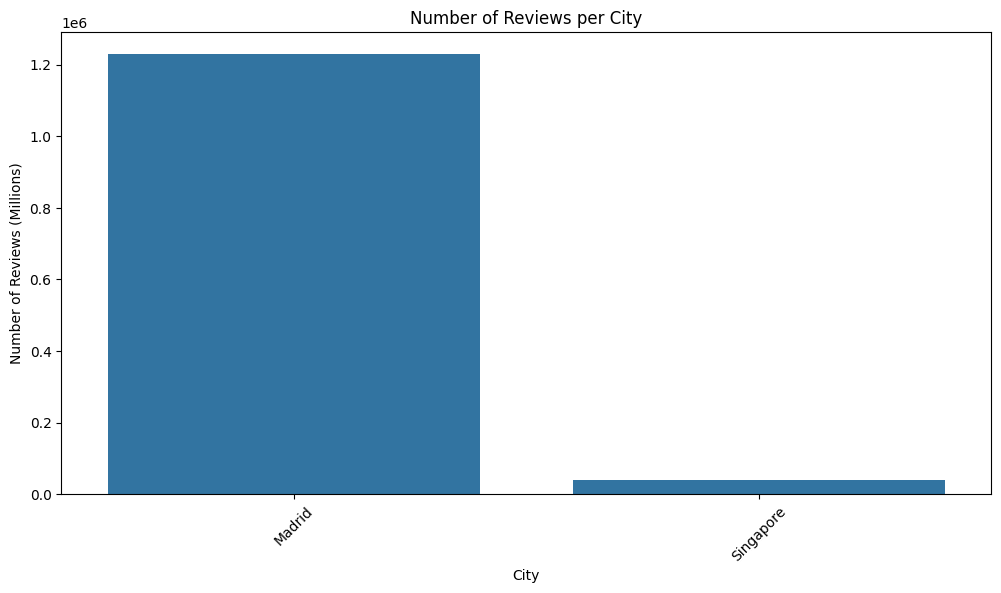

<Figure size 640x480 with 0 Axes>

In [5]:
#Show the distribution of number of reviews per city, make clear that it are millions of reviews
plt.figure(figsize=(12,6))
sns.countplot(data=reviews_combined, x='city', order=reviews_combined['city'].value_counts().index)
plt.xlabel('City')
plt.ylabel('Number of Reviews (Millions)')
plt.title('Number of Reviews per City')
plt.xticks(rotation=45)
plt.show()
plt.savefig('reviews_per_city_before_preprocessing.png')


Explanation of the Code

Language Filtering: We use TextBlob to detect the language of each review in the comments column, keeping only English reviews.

Text Preprocessing: We clean the comments by removing special characters and converting text to lowercase for consistency in the topic modeling step.

Topic Modeling: Using LDA with a CountVectorizer, we extract topics. You can adjust the number of topics (n_components) as needed.

Sentiment Analysis: For sentiment scoring, we calculate the polarity of each review using TextBlob, which provides a sentiment score between -1 (negative) and 1 (positive).

Aggregation: We group the reviews by listing_id and calculate the average sentiment score per listing.

This code will output a DataFrame, average_sentiment_per_listing, containing each listing's average sentiment score. This can be used for further analysis on how review sentiment correlates with listing performance.

In [6]:
reviews_combined.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,city
0,21853,21051116,2014-10-10,8506071,Pedro Abel,"Mi experiencia en casa de Adel fue buena, aunque al principio costo un poco ponernos de acuerdo para hacer la entrada al final conseguimos encontrar una hora conveniente para los dos. Aunque la casa y en especial la cocina estaba algo desordenada la habitación si estaba limpia y ordenada. El sitio es un barrio tranquilo y bien comunicado.",Madrid
1,21853,21268157,2014-10-13,19062863,Olga,"Adel is a very warm person and thoughtful! He didn't have a hairdryer, but he bought one the next morning! Pretty cool, right? :) and the room has a nice view of the city, plus it's close to a park from where you can get great shots!",Madrid
2,21853,22527396,2014-11-09,6099461,Hugh,"Adel is an exceptionally welcoming host. I was ill during my stay and he was kind enough to accompany me to the doctor to translate for me! He really is an exceptionally pleasant person, very laid back and an interesting, knowledgable and articulate talker, even though he claims his English isn't that good! I couldn't recommend staying with him more highly.",Madrid
3,21853,22684525,2014-11-11,23357657,Sendy,"Adel fue muy amable, incluso el día de mi llegada fue por mi a la salida del metro y me ayudó con mi equipaje :). Durante mi estancia fue muy respetuoso y agradable, me explicó cómo funcionaban las cosas, me dió algunos tips para ahorrar. Es muy buen conversador y un a persona flexible en cuanto al check in y check out.\r<br/>\r<br/>La habitación es suficiente para una persona, estaba limpio y como soy muy friolenta Adel me ofreció cobijas extra. No tuve problemas con el internet. \r<br/>\r<br/>Gracias Adel.\r<br/>",Madrid
4,21853,22871843,2014-11-16,4072731,Nati,"Abdel ha sido un magnífico anfitrión y la mejor forma que se me ocurre para describirlo es que me he sentido como en mi propia casa. Además, la casa es bonita, está limpia y es muy cómoda. Todo muy recomendable con ellos.",Madrid


In [7]:
reviews_combined['listing_id'].nunique()

23088

In [8]:
reviews_combined['listing_id'].value_counts()

listing_id
16889632               1092
3908928                 986
51558636                970
29172802                965
3397465                 942
47945468                908
7783777                 904
9128910                 890
93100                   888
17735333                857
5170938                 839
9471684                 839
526513                  823
2452815                 797
16675905                796
3727205                 794
2862015                 792
838698                  790
28237489                777
709208                  766
21455170                766
11550407                760
6287069                 751
20200455                749
567301424368343959      748
1523675                 744
6287397                 743
18093383                728
576487                  726
2355344                 720
18702124                714
12064892                714
28891765                712
5756228                 709
23674514                709
23674750 

In [9]:
#add new word count column
reviews_combined['word_count'] = reviews_combined['comments'].apply(lambda x: len(str(x).split()))

In [10]:
# Step 1: Randomly sample 10,000 unique listing IDs
sampled_listing_ids = reviews_combined['listing_id'].drop_duplicates().sample(n=100, random_state=42)

# Step 2: Filter the DataFrame to include all reviews for the sampled listings
reviews_combined_sample = reviews_combined[reviews_combined['listing_id'].isin(sampled_listing_ids)]

# Step 3: Check the resulting shape
reviews_combined_sample.shape


(7475, 8)

In [11]:
reviews_combined.shape

(1267742, 8)

In [ ]:
# Download required NLTK data
nltk.download('punkt')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Step 1: Sample data and handle missing values
df = reviews_combined
df = reviews_combined.dropna(subset=['comments'])

# Step 2: Filter for English reviews
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

df['is_english'] = df['comments'].apply(is_english)
df = df[df['is_english']]
if len(df) == 0:
    raise ValueError("No English reviews found after filtering.")

# Step 3: Preprocess text (remove stopwords)
stopwords = set(ENGLISH_STOP_WORDS)

def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text.lower())  # Remove non-alphanumeric characters
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords])

df['cleaned_comments'] = df['comments'].apply(preprocess_text)
df = df[df['cleaned_comments'].str.len() > 2]
if len(df) == 0:
    raise ValueError("No comments left after preprocessing.")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\PC\AppData\Local\Temp\ipykernel_16380\2409800773.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_english'] = df['comments'].apply(is_english)


In [ ]:
# Step 4: Identify and remove words in more than 10% of the reviews
print(f"Original dataframe shape: {df.shape}")

df2 = df.sample(frac=0.1, random_state=42)
print(f"Sampled dataframe shape (10% of data): {df2.shape}")

# Create a Counter to count word occurrences across reviews
word_in_reviews_count = Counter()

# Iterate through each comment and add unique words to the counter
for idx, comment in enumerate(df2['cleaned_comments']):
    unique_words = set(comment.split())  # Use set to count each word only once per review
    word_in_reviews_count.update(unique_words)

    # Print every 100,000th review to understand progress
    if (idx + 1) % 100000 == 0:
        print(f"Processed {idx + 1} reviews.")

# Calculate words that occur in more than 10% of the reviews without storing all frequencies
total_reviews = len(df2)
frequent_words = []

# Iterate through the counter to find words that are in more than 10% of the reviews
for word, count in word_in_reviews_count.items():
    if count / total_reviews > 0.1:
        frequent_words.append(word)

print(f"\nTotal unique words considered: {len(word_in_reviews_count)}")
print(f"Words removed for being in more than 10% of the reviews: {len(frequent_words)}")






Original dataframe shape: (532096, 10)
Sampled dataframe shape (10% of data): (53210, 10)

Total unique words considered: 24021
Words removed for being in more than 10% of the reviews: 24


In [14]:
print(f"List of frequent words : {frequent_words}")

List of frequent words : ['clean', 'place', 'comfortable', 'close', 't', 'br', 'host', 'metro', 'apartment', 'location', 'madrid', 'stay', 'great', 'easy', 'recommend', 'perfect', 'really', 's', 'good', 'restaurants', 'helpful', 'nice', 'definitely', 'located']


In [15]:
#Save frequent words as csv
frequent_words_df = pd.DataFrame(frequent_words)
frequent_words_df.to_csv('frequent_words_outofsample.csv', index=False)

In [ ]:
# Step 4b: Define function to remove frequent words
def remove_frequent_words(text, frequent_words_set):
    words = text.split()
    return ' '.join(word for word in words if word not in frequent_words_set)

# Convert frequent words list to a set for faster lookup
frequent_words_set = set(frequent_words)
print(f"Number of frequent words to remove: {len(frequent_words_set)}")

# Apply filtering in batches to avoid memory issues
batch_size = 100000
filtered_comments = []

print("Starting to filter comments in batches...")
for start in range(0, len(df), batch_size):
    end = min(start + batch_size, len(df))
    df_batch = df.iloc[start:end]
    df_batch['filtered_comments'] = df_batch['cleaned_comments'].apply(lambda text: remove_frequent_words(text, frequent_words_set))
    filtered_comments.append(df_batch)

# Concatenate all filtered batches to create the final DataFrame
df = pd.concat(filtered_comments, ignore_index=True)

# Remove comments that are empty or too short after filtering
df = df[df['filtered_comments'].str.len() > 2]
print(f"Dataframe shape after removing empty or very short comments: {df.shape}")

if len(df) == 0:
    raise ValueError("No comments left after filtering frequent words.")

# Step 5: Pre-sort the data for consistency
df = df.sort_values(by='listing_id').reset_index(drop=True)
print(f"Dataframe shape after sorting by listing_id: {df.shape}")

# Step 6: Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Adding debug statements before and after transformation
print("Starting TF-IDF vectorization...")
X = vectorizer.fit_transform(df['filtered_comments'])
print("TF-IDF vectorization completed.")
print(f"TF-IDF matrix shape: {X.shape}")
print(f"Number of non-zero elements in the TF-IDF matrix: {X.nnz}")
print(f"Memory required for the TF-IDF matrix (approximate): {X.nnz * 8 / (1024**3):.2f} GB")



Number of frequent words to remove: 24
Starting to filter comments in batches...


C:\Users\PC\AppData\Local\Temp\ipykernel_16380\4010352450.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['filtered_comments'] = df_batch['cleaned_comments'].apply(lambda text: remove_frequent_words(text, frequent_words_set))
C:\Users\PC\AppData\Local\Temp\ipykernel_16380\4010352450.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['filtered_comments'] = df_batch['cleaned_comments'].apply(lambda text: remove_frequent_words(text, frequent_words_set))
C:\Users\PC\AppData\Local\Temp\i

Dataframe shape after removing empty or very short comments: (513721, 11)
Dataframe shape after sorting by listing_id: (513721, 11)
Starting TF-IDF vectorization...
TF-IDF vectorization completed.
TF-IDF matrix shape: (513721, 5000)
Number of non-zero elements in the TF-IDF matrix: 8813483
Memory required for the TF-IDF matrix (approximate): 0.07 GB


In [ ]:
#Save the TF-IDF matrix
scipy.sparse.save_npz('tfidf_matrix.npz', X)


In [18]:
# Step 7: Define the number of topics for LDA and train with fixed random state
num_topics = 4
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Step 8: Extract topic words
feature_names = vectorizer.get_feature_names_out()
topic_words = {
    topic_idx: [feature_names[i] for i in topic.argsort()[-15:][::-1]]
    for topic_idx, topic in enumerate(lda.components_)
}

print("\nTop Words per Topic:")
for topic_idx, words in topic_words.items():
    print(f"Topic #{topic_idx + 1}: {words}")

# Step 9: Assign topics to reviews
topic_assignments = lda.transform(X)
df['assigned_topic'] = topic_assignments.argmax(axis=1)




Top Words per Topic:
Topic #1: ['amazing', 'super', 'responsive', 'check', 'thank', 'friendly', 'wonderful', 'hosts', 'thanks', 'time', 'beautiful', 'highly', 'enjoyed', 'communication', 'loved']
Topic #2: ['home', 'station', 'walk', 'house', 'walking', 'airport', 'like', 'felt', 'kind', 'feel', 'come', 'time', 'room', 'distance', 'train']
Topic #3: ['city', 'highly', 'excellent', 'center', 'flat', 'lovely', 'quiet', 'distance', 'recommended', 'walking', 'bars', 'walking distance', 'communication', 'central', 'need']
Topic #4: ['room', 'small', 'bed', 'night', 'bit', 'kitchen', 'bathroom', 'plaza', 'like', 'just', 'shower', 'people', 'little', 'noise', 'street']


In [19]:
#Save df as csv
df.to_csv('reviews_combined_lda_out_of_sample.csv', index=False)

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Step 10: Sentiment Analysis using VADER
def vader_sentiment(text):
    return sia.polarity_scores(str(text))['compound']  # Convert text to string to avoid issues

df['sentiment_score'] = df['comments'].apply(vader_sentiment)

# Step 11: Assign sentiment scores to each topic column for each review
for topic_num in range(num_topics):
    df[f'sentiment_topic_{topic_num}'] = np.where(df['assigned_topic'] == topic_num, df['sentiment_score'], 0)

# Step 12: Calculate average sentiment score per topic per listing_id
average_sentiment_per_topic_listing = df.groupby('listing_id').agg({
    'sentiment_topic_0': 'mean',
    'sentiment_topic_1': 'mean',
    'sentiment_topic_2': 'mean',
    'sentiment_topic_3': 'mean'
}).reset_index()




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
#Step 13: Add the average word count per listing of original reviews_combined to the dataframe
average_word_count_per_listing = df.groupby('listing_id').agg({
    'word_count': 'mean'
}).reset_index()
average_sentiment_per_topic_listing= average_sentiment_per_topic_listing.merge(average_word_count_per_listing, on='listing_id')
average_sentiment_per_topic_listing.rename(columns={'word_count':'average_word_count'}, inplace=True)

# Display the result
print("\nAverage Sentiment Score per Topic for Each Listing:")
print(average_sentiment_per_topic_listing.head())


Average Sentiment Score per Topic for Each Listing:
   listing_id  sentiment_topic_0  sentiment_topic_1  sentiment_topic_2  \
0       21853           0.047753           0.601576           0.095859   
1       24805           0.000000           0.073346           0.612869   
2       30320           0.144691           0.171866           0.182414   
3       30959           0.470500           0.000000           0.118850   
4       40718           0.170340           0.318177           0.151159   

   sentiment_topic_3  average_word_count  
0           0.168053           58.823529  
1           0.144185           47.692308  
2           0.348264           64.684211  
3           0.000000           33.500000  
4           0.251771           60.701149  


In [23]:
average_sentiment_per_topic_listing.shape


(19621, 6)

In [24]:
#count duplicates
average_sentiment_per_topic_listing.duplicated().sum()

np.int64(0)

In [25]:
#save the result as csv
average_sentiment_per_topic_listing.to_csv('average_sentiment_per_topic_listing_out_of_sample.csv', index=False)